In [1]:
import os
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import polars as pl
from warnings import simplefilter
simplefilter('ignore')
%matplotlib inline

In [2]:
df = pl.read_csv('/work/InternalMedicine/s223850/ED-StaticDynamic/raw_data/ED Events - 12.21.23.csv',
                 infer_schema_length=int(1e6),
                 null_values=dict(Patient_Age='NULL'),
                 dtypes=dict(Patient_Age=pl.Float64)
                )

In [3]:
df = df.with_columns([
    pl.col("Arrived_Time").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S%.f"),
    pl.col("Calculated_DateTime").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S%.f"),
])

In [4]:
# Include only admitted/discharged ed_disposition that occured in or after 2021 
df = df.filter((pl.col("Calculated_DateTime").dt.year()>=2021)&(pl.col("ED_Disposition").is_not_null())&(pl.col("ED_Disposition").is_in(['Admitted', 'Discharged']))).sort("Calculated_DateTime")

In [5]:
admitted_with_order = df.filter(pl.col('ED_Disposition')=='Admitted').\
                      group_by('PAT_ENC_CSN_ID').\
                      agg([
                          pl.col('Type').apply(lambda x: 'Order - Admission' in x).alias('has_admission_order')
                      ])

In [6]:
admi_pats_with_no_order = admitted_with_order.filter(pl.col('has_admission_order')==False).select(pl.col('PAT_ENC_CSN_ID'))

In [7]:
df = df.filter(~pl.col('PAT_ENC_CSN_ID').is_in(admi_pats_with_no_order))

# Add elapsed time and reversed elapsed time

In [8]:
dd = df.group_by("PAT_ENC_CSN_ID").map_groups(lambda x: x[:np.where(x['Type']=='Order - Admission')[0][0]+1] if 'Order - Admission' in x['Type'] else x)

In [9]:
de = dd.with_columns([
    (pl.col("Calculated_DateTime")-pl.col("Arrived_Time")).dt.total_seconds().alias('elapsed_time_sec'),
    (pl.col("Calculated_DateTime")-pl.col("Arrived_Time")).dt.total_hours().alias('elapsed_time_hr'),
])

In [10]:
dee = de.group_by(
    'PAT_ENC_CSN_ID'
).map_groups(
    lambda x: x.with_columns((-1*(pl.col("elapsed_time_sec")-x.get_column("elapsed_time_sec")[-1])).alias('inv_elapsed_sec'))
)
dee = dee.with_columns(
    (pl.col("inv_elapsed_sec")/60).alias('inv_elapsed_min'),
    (pl.col("inv_elapsed_sec")/60/60).alias('inv_elapsed_hr'),
)

<Axes: ylabel='Density'>

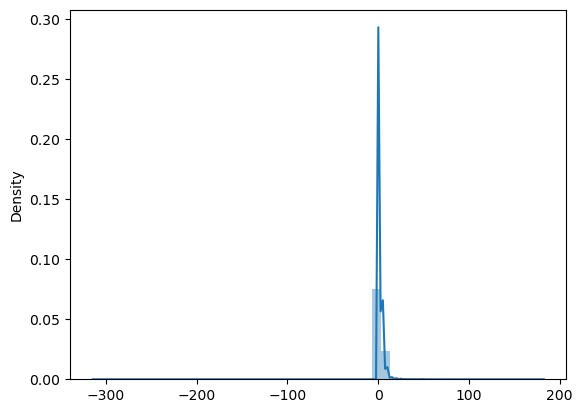

In [11]:
sns.distplot(dee.filter(pl.col('ED_Disposition')=='Admitted')['elapsed_time_hr'].to_numpy())

<Axes: ylabel='Density'>

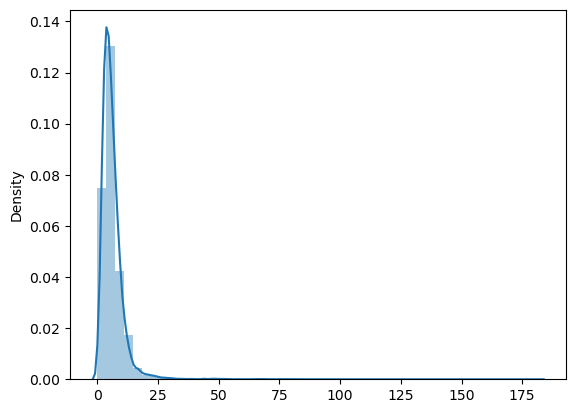

In [12]:
pat_2_discard = dee.filter(pl.col('elapsed_time_hr')<0).select(pl.col('PAT_ENC_CSN_ID')).unique()
admitted_elapsed_time = dee.filter(~pl.col('PAT_ENC_CSN_ID').is_in(pat_2_discard)).filter(pl.col('Type')=='Order - Admission').select(pl.col('elapsed_time_hr'))
sns.distplot(admitted_elapsed_time)

In [13]:
# nevents = dee.filter(pl.col('ED_Disposition')=='Admitted').\
#          group_by('PAT_ENC_CSN_ID').\
#          agg([pl.len().alias('# events'), pl.col('elapsed_time_hr').last()]) 
def get_last_event(df, cnt):
    if len(df)>=cnt:
        return df[-cnt]
    else:
        return 0
nevents = dee.group_by('PAT_ENC_CSN_ID').agg([pl.len().alias('# events'),
                                              pl.col('elapsed_time_hr').apply(lambda x: get_last_event(x, 10)),
                                              pl.col('ED_Disposition').last(),
                                              pl.col('inv_elapsed_hr').apply(lambda x: get_last_event(x, 100)) 
                                             ])
nevents.filter(pl.col('ED_Disposition')=='Admitted')['inv_elapsed_hr'].mean(), nevents.filter(pl.col('ED_Disposition')=='Discharged')['inv_elapsed_hr'].mean()

(4.18900134358274, 3.683373385178197)

In [14]:
nevents.filter(pl.col('ED_Disposition')=='Admitted')['inv_elapsed_hr'].mean(), nevents.filter(pl.col('ED_Disposition')=='Discharged')['inv_elapsed_hr'].mean()

(4.18900134358274, 3.683373385178197)

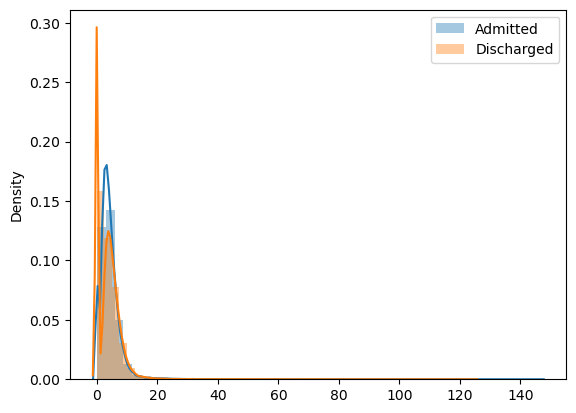

In [15]:
ax = sns.distplot(nevents.filter(pl.col('ED_Disposition')=='Admitted')['inv_elapsed_hr'].to_numpy(), label='Admitted')
sns.distplot(nevents.filter(pl.col('ED_Disposition')=='Discharged')['inv_elapsed_hr'].to_numpy(), label='Discharged')
# sns.distplot(nevents'inv_elapsed_hr'].to_numpy())#, label='Discharged')

plt.legend()

In [16]:
nevents_freq = nevents.with_columns((pl.col('# events')/(pl.col('elapsed_time_hr')+0.01)).alias('overall_freq'))

In [17]:
nevents_freq

PAT_ENC_CSN_ID,# events,elapsed_time_hr,ED_Disposition,inv_elapsed_hr,overall_freq
i64,u32,i64,str,f64,f64
682425665,136,6,"""Discharged""",5.140833,22.628952
693672451,131,16,"""Admitted""",3.775833,8.182386
657665062,145,2,"""Admitted""",1.366667,72.139303
684391600,192,7,"""Admitted""",8.883333,27.389444
656981215,144,3,"""Admitted""",3.639722,47.840532
…,…,…,…,…,…
675581318,165,8,"""Discharged""",3.720556,20.599251
673436591,152,6,"""Admitted""",6.1,25.291181
680076970,189,4,"""Admitted""",2.55,47.13217


In [18]:
preprocessed_main_dir = "/work/InternalMedicine/s223850/ED-StaticDynamic/static_dynamic_feats_ID_240324/tr_8_te_4"
main_dir = "/project/InternalMedicine/Basit_lab/s223850/ED-StaticDynamic/ml_results_240324/tr_8_te_4/run_1/"
def jobobj2featmat(f1, modelname='cat', topfeats=20):
    return pd.DataFrame(f1[modelname]['model'].feature_importances_, index=f1[modelname]['model'].feature_names_).reset_index().rename(columns={'index':'names', 0:'importance'}).sort_values(by='importance', ascending=False).iloc[:topfeats]
all_dir = os.path.join(main_dir, 'all')
all_sorted_feats = sorted(os.listdir(all_dir), key=lambda x: (int(x.split('_')[2]),int(x.split('_')[-1].split('.')[0])))

In [19]:
event_index_feats = {}
bacc_mean = []
bacc_std = []

ppv_mean = []
ppv_std = []

event_idx = []
for idx in range(0, len(all_sorted_feats), 2):
    iidx = int(all_sorted_feats[idx].split('_')[2])
    event_idx.append(iidx)
    assert(all_sorted_feats[idx].split('_')[2] == all_sorted_feats[idx+1].split('_')[2])
    with open(os.path.join(all_dir, all_sorted_feats[idx]), 'rb') as f:
        f1 = joblib.load(f)
        feats1 = jobobj2featmat(f1)
    with open(os.path.join(all_dir, all_sorted_feats[idx+1]), 'rb') as f:
        f2 = joblib.load(f)
        feats2 = jobobj2featmat(f2)
    common_events = np.intersect1d(feats1['names'].values, feats2['names'].values)
    event_index_feats[iidx] = common_events
    bacc_mean.append(f1['cat']['val_score_avg']['bacc'])
    bacc_std.append(f1['cat']['val_score_std']['bacc'])
    ppv_mean.append(f1['cat']['val_score_avg']['ppv'])
    ppv_std.append(f1['cat']['val_score_std']['ppv'])

In [43]:
event_index_feats[200]

array(['Acuity_Level', 'Event_assignattending', 'Event_avsprinted',
       'Event_consulttrackingstarted', 'Event_dischargeavsprintsnapshot',
       'Event_dischargestatuschange',
       'Event_famdischargeavsprintsnapshot',
       'Event_fileassignattendingandfirstprovidercontact',
       'Event_hospitalistadmitsconsultcalled',
       'Event_hospitalistadmitsconsultordered', 'Event_labordered',
       'Number of past appointments in last 60 days',
       'Order - Admission_potentialadmissionbedboardnotification',
       'Order - Nursing_ednuredconsultspecify',
       'Order - Nursing_ipnurcalldoctor', 'rare_Event',
       'rare_Lab Order - Result'], dtype=object)

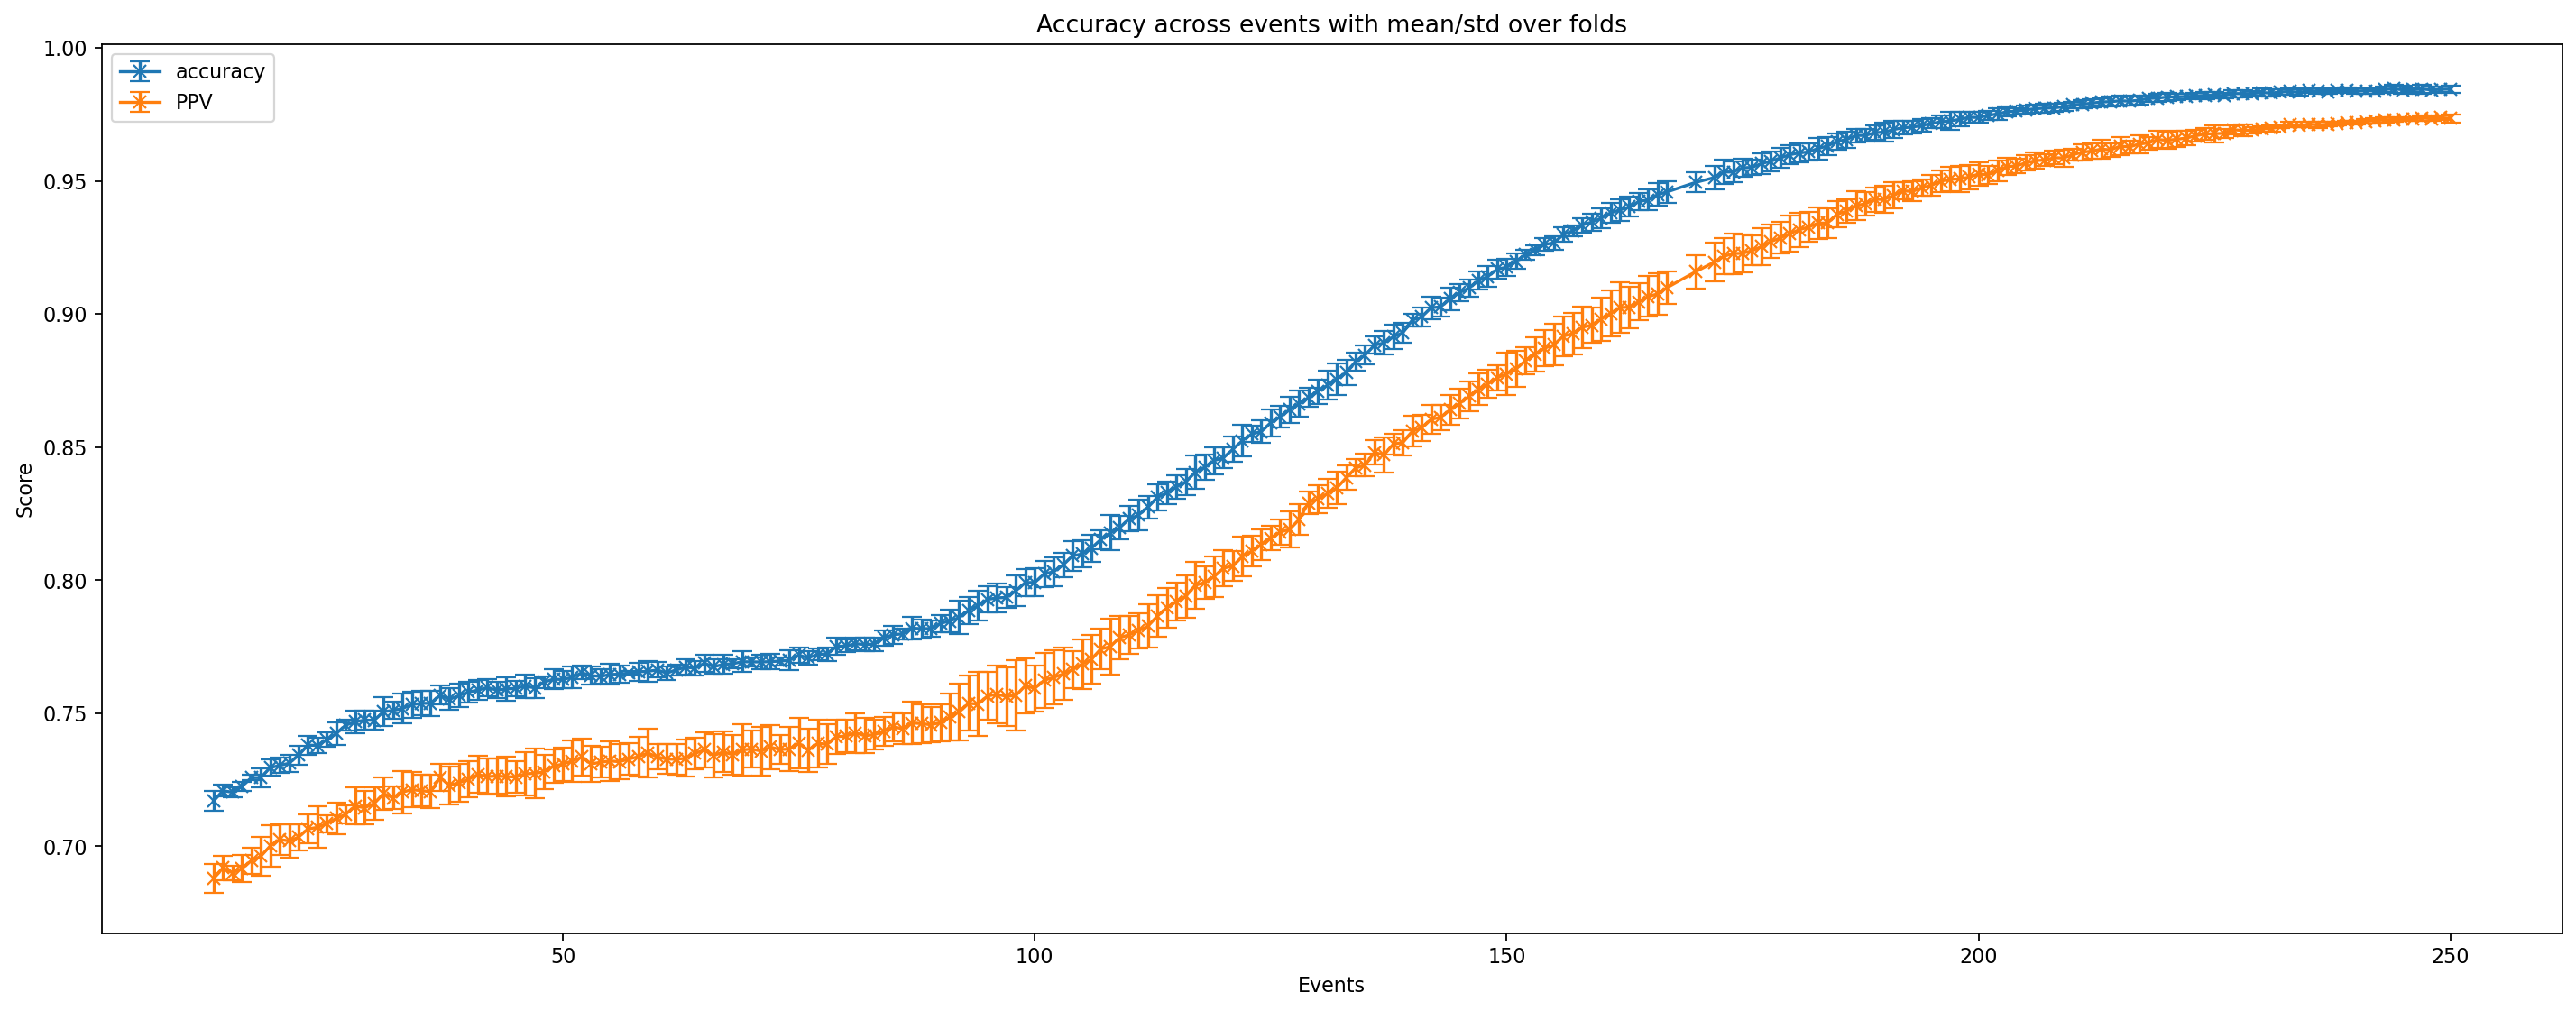

In [21]:
fig, ax = plt.subplots(figsize=(22,8), dpi=160)
plt.errorbar(event_idx, bacc_mean, yerr=bacc_std, fmt='-x', capsize=5, label='accuracy')
plt.errorbar(event_idx, ppv_mean, yerr=ppv_std, fmt='-x', capsize=5, label='PPV')

plt.ylabel('Score')
plt.xlabel('Events')
plt.title("Accuracy across events with mean/std over folds")

fig.savefig("error.png")
plt.legend()
plt.show()


In [34]:
nevents_before_admiorder = 50

In [35]:
# nevents = dee.filter(pl.col('ED_Disposition')=='Admitted').\
#          group_by('PAT_ENC_CSN_ID').\
#          agg([pl.len().alias('# events'), pl.col('elapsed_time_hr').last()]) 
def get_last_event(df, cnt):
    if len(df)>=cnt:
        return df[-cnt]
    else:
        return None
nevents = dee.group_by('PAT_ENC_CSN_ID').agg([pl.len().alias('# events'),
                                              pl.col('elapsed_time_hr').apply(lambda x: get_last_event(x, nevents_before_admiorder)),
                                              pl.col('ED_Disposition').last(),
                                              pl.col('inv_elapsed_hr').apply(lambda x: get_last_event(x, nevents_before_admiorder)) 
                                             ])
nevents.filter(pl.col('ED_Disposition')=='Admitted')['inv_elapsed_hr'].mean(), nevents.filter(pl.col('ED_Disposition')=='Discharged')['inv_elapsed_hr'].mean()

(2.991750600963045, 3.815762898295912)

In [37]:
# nevents

In [36]:
bacc_mean[-50]

0.974615248494357

In [40]:
def get_idx_event(df, idx):
    if len(df) >= idx:
        return df[-idx]
    else:
        return 'SHORT'
eventsofinterest = dee.group_by('PAT_ENC_CSN_ID').agg(pl.col("EVENT_NAME").apply(lambda x: get_idx_event(x, 50)))

In [41]:
eventsofinterest['EVENT_NAME'].value_counts().sort(by='count', descending=True).to_pandas()['EVENT_NAME'].iloc[:10]

0                        SHORT
1          ED Lactate Resulted
2    Pt rounding timer started
3        Pt rounding completed
4                 Lab Resulted
5                TROPONIN I HS
6      Re-assessment completed
7               Patient Moving
8    Re-assessment timer reset
9                 Assign Nurse
Name: EVENT_NAME, dtype: object

In [ ]:
##################################################

In [63]:
nevents_freq.group_by('ED_Disposition').agg([pl.col('overall_freq').median()])

ED_Disposition,overall_freq
str,f64
"""Admitted""",29.341317
"""Discharged""",21.695761


In [67]:
nevents_freq.group_by('ED_Disposition').agg([pl.col('# events').median()])

ED_Disposition,# events
str,f64
"""Discharged""",123.0
"""Admitted""",151.0


In [70]:
nevents_freq.group_by('ED_Disposition').agg([pl.col('elapsed_time_hr').mean()])

ED_Disposition,elapsed_time_hr
str,f64
"""Discharged""",5.898988
"""Admitted""",6.112222


In [85]:
event_per_pat_count = dee.group_by(['ED_Disposition', 'EVENT_NAME']).agg([
    pl.len().alias('count')
]).sort(by='count', descending=True).with_columns(pl.col('count')/pl.col('count').sum())
event_per_pat_count.filter(event_per_pat_count['count'].cumsum()<=0.95).filter(pl.col('ED_Disposition')=='Admitted').select(pl.col('EVENT_NAME'))[:50].to_numpy()

array([['Lab Ordered'],
       ['ED Lactate Resulted'],
       ['Pt rounding timer started'],
       ['Pt rounding completed'],
       ['TROPONIN I HS'],
       ['Patient Moving'],
       ['Lab Resulted'],
       ['CBC W/ DIFF'],
       ['CBC WITH DIFFERENTIAL'],
       ['Initial ED Provider Contact'],
       ['Re-assessment completed'],
       ['Re-assessment timer reset'],
       ['ED Course - Free Text'],
       ['Assign Nurse'],
       ['URINALYSIS + REFLEX MICROSCOPIC'],
       ['XR CHEST 1 VIEW'],
       ['CMPL (COMPREHENSIVE METABOLIC PANEL)'],
       ['Consult tracking started'],
       ['ED Note Pended'],
       ['LACTATE (LACTIC ACID) SERUM'],
       ['Assign Attending'],
       ['File Assign Attending and First Provider Contact'],
       ['BNP'],
       ['GLUCOSE POC METER'],
       ['Patient roomed in ED'],
       ['Prev Admission Rec Generated'],
       ['Emergency encounter created'],
       ['Admission FAM List Generated'],
       ['Admission Med List Generated'],
      

In [86]:
event_per_pat_count.filter(event_per_pat_count['count'].cumsum()<=0.95).filter(pl.col('ED_Disposition')=='Discharged').select(pl.col('EVENT_NAME'))[:50].to_numpy()

array([['Pt rounding timer started'],
       ['Pt rounding completed'],
       ['Patient Moving'],
       ['Re-assessment completed'],
       ['Re-assessment timer reset'],
       ['Lab Ordered'],
       ['Initial ED Provider Contact'],
       ['Assign Nurse'],
       ['ED Lactate Resulted'],
       ['CBC WITH DIFFERENTIAL'],
       ['CBC W/ DIFF'],
       ['TROPONIN I HS'],
       ['Lab Resulted'],
       ['ED Course - Free Text'],
       ['ED Note Pended'],
       ['URINALYSIS + REFLEX MICROSCOPIC'],
       ['Discharge AVS Print Snapshot'],
       ['FAM Discharge AVS Print Snapshot'],
       ['AVS Printed'],
       ['Assign Attending'],
       ['File Assign Attending and First Provider Contact'],
       ['Discharge Status Change'],
       ['CMPL (COMPREHENSIVE METABOLIC PANEL)'],
       ['Patient roomed in ED'],
       ['Prev Admission Rec Generated'],
       ['Emergency encounter created'],
       ['Admission FAM List Generated'],
       ['Admission Med List Generated'],
       ['Pa

<Axes: ylabel='Density'>

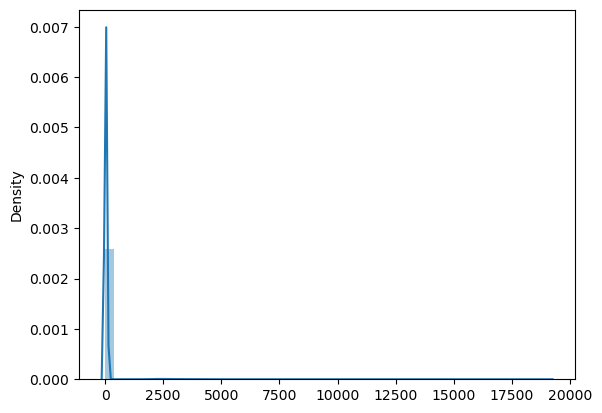

In [55]:
sns.distplot(nevents_freq.select(pl.col('overall_freq')).to_numpy().ravel())

In [26]:
dee.filter(pl.col('PAT_ENC_CSN_ID') == 689525475).with_columns([
    pl.arange(0, pl.col('EVENT_NAME').len()).alias('count')
]).select([pl.col('Calculated_DateTime'), pl.col('Type'), pl.col('EVENT_NAME'), pl.col('elapsed_time_hr'), pl.col('count')]) 

Calculated_DateTime,Type,EVENT_NAME,elapsed_time_hr,count
datetime[ns],str,str,i64,i64
2023-09-20 09:33:02,"""Event""","""Emergency enco…",0,0
2023-09-20 09:33:13,"""Event""","""Admission FAM …",0,1
2023-09-20 09:33:13,"""Event""","""Patient arrive…",0,2
2023-09-20 09:33:13,"""Event""","""Admission Med …",0,3
2023-09-20 09:33:13,"""Event""","""Prev Admission…",0,4
…,…,…,…,…
2023-09-20 15:19:47,"""Event""","""Pt rounding co…",5,205
2023-09-20 15:19:47,"""Event""","""Re-assessment …",5,206
2023-09-20 15:19:47,"""Event""","""Pt rounding ti…",5,207


In [32]:
dee = dee.with_columns([
    pl.arange(0, pl.len()).over('PAT_ENC_CSN_ID').alias('count')
]).\
select([pl.col('Calculated_DateTime'), pl.col('Type'), pl.col('EVENT_NAME'), pl.col('elapsed_time_hr'), pl.col('count')]) 

In [34]:
dee

Calculated_DateTime,Type,EVENT_NAME,elapsed_time_hr,count
datetime[ns],str,str,i64,i64
2023-04-03 18:24:38,"""Event""","""Emergency enco…",0,0
2023-04-03 18:24:51,"""Event""","""Admission FAM …",0,1
2023-04-03 18:24:51,"""Event""","""Admission Med …",0,2
2023-04-03 18:24:51,"""Event""","""Patient arrive…",0,3
2023-04-03 18:24:52,"""Event""","""Prev Admission…",0,4
…,…,…,…,…
2021-12-23 16:28:19,"""Event""","""POSS Documente…",1,51
2021-12-23 16:28:19,"""Event""","""Re-assessment …",1,52
2021-12-23 16:28:19,"""Event""","""Pt rounding co…",1,53


In [33]:
dee.filter(pl.col('PAT_ENC_CSN_ID') == 689525475).select([pl.col('Calculated_DateTime'), pl.col('Type'), pl.col('EVENT_NAME'), pl.col('elapsed_time_hr')])

ColumnNotFoundError: unable to find column "PAT_ENC_CSN_ID"; valid columns: ["Calculated_DateTime", "Type", "EVENT_NAME", "elapsed_time_hr", "count"]

Error originated just after this operation:
DF ["Calculated_DateTime", "Type", "EVENT_NAME", "elapsed_time_hr"]; PROJECT */5 COLUMNS; SELECTION: "None"

In [74]:
dee = dee.with_columns(
    (pl.col("Type") == "Order - Admission").cumsum().over("PAT_ENC_CSN_ID").alias("cumulative_admission")
)

# Filter to get admitted rows
admitted = dee.filter(pl.col('ED_Disposition')=='Admitted')

# Step 2: Mark rows before the first 'Order - Admission' (cumulative_admission will be 1 at first occurrence)
# Use the mask to count rows that are marked as 0 in 'cumulative_admission' (before the first 'Order - Admission')
counts = admitted.with_columns(
    (pl.col("cumulative_admission") == 0).alias("count_before_admission")
).group_by("PAT_ENC_CSN_ID").agg(
    pl.sum("count_before_admission").alias("# events before")
)


In [86]:
counts.join(nevents, on='PAT_ENC_CSN_ID', how='outer').join(dee.filter(~pl.col('PAT_ENC_CSN_ID').is_in(pat_2_discard)).filter(pl.col('Type')=='Order - Admission').select([pl.col('PAT_ENC_CSN_ID'), pl.col('elapsed_time_hr')]), on='PAT_ENC_CSN_ID', suffix='rr',how='outer')

PAT_ENC_CSN_ID,# events before,PAT_ENC_CSN_ID_right,# events,PAT_ENC_CSN_IDrr,elapsed_time_hr
i64,u32,i64,u32,i64,i64
691286665,145,691286665,146,691286665,5
670934542,143,670934542,144,670934542,4
663120737,88,663120737,89,663120737,10
676903138,141,676903138,142,676903138,6
679168329,149,679168329,150,679168329,5
…,…,…,…,…,…
689863507,164,689863507,165,null,null
653886989,117,653886989,118,null,null
673350250,195,673350250,196,null,null


In [10]:
dee.filter(pl.col('elapsed_time_hr')<0).group_by('PAT_ENC_CSN_ID').agg(
    [
        pl.len().alias('count'),
        pl.col('elapsed_time_hr').min().alias('min_elapsed_hr'),
        pl.col('Arrived_Time').first(),
        pl.col('Calculated_DateTime').first(),
        pl.col('EVENT_NAME').first(),
        pl.col('Type').first()
    ]
).sort('min_elapsed_hr').select(['PAT_ENC_CSN_ID', 'Type', 'EVENT_NAME']).to_numpy()

array([[682315360, 'Event', 'Appointment Scheduled'],
       [674253556, 'Lab Order - Result', 'ALBUMIN'],
       [661002521, 'Event', 'Admission Order Rec Public Pend'],
       [678090269, 'Order - Lab',
        'HCV RNA,QN REAL-TIME PCR W/RFLX TO QL'],
       [675563577, 'Lab Order - Result', 'ACETONE, UR'],
       [673350250, 'Order - Procedures', 'Other Procedure'],
       [653886989, 'Order - Procedures', 'PFT STANDARD TESTING'],
       [691164107, 'Lab Order - Result', 'TOTAL PROTEIN'],
       [686478815, 'Order - Procedures', 'INCISION AND DRAINAGE'],
       [669649728, 'Order - Procedures', 'LACERATION REPAIR'],
       [671203711, 'Order - Procedures', 'LACERATION REPAIR'],
       [682806224, 'Order - Procedures', 'CHEST TUBE INSERTION'],
       [671621452, 'Event', 'Admission Order Rec Public Pend'],
       [689863507, 'Event', 'Admit started']], dtype=object)

In [13]:
df.filter(pl.col('PAT_ENC_CSN_ID')==691164107).select(["Arrived_Time", "Calculated_DateTime", "Type", "EVENT_NAME", "ED_Disposition"]).to_pandas()

,Arrived_Time,Calculated_DateTime,Type,EVENT_NAME,ED_Disposition
0,2023-10-13 14:11:58,2023-10-13 00:00:00,Lab Order - Result,TOTAL PROTEIN,Admitted
1,2023-10-13 14:11:58,2023-10-13 00:00:00,Lab Order - Result,A/G RATIO,Admitted
2,2023-10-13 14:11:58,2023-10-13 00:00:00,Lab Order - Result,ALBUMIN,Admitted
3,2023-10-13 14:11:58,2023-10-13 00:00:00,Lab Order - Result,CALCIUM,Admitted
4,2023-10-13 14:11:58,2023-10-13 00:00:00,Lab Order - Result,EGFR,Admitted
...,...,...,...,...,...
179,2023-10-13 14:11:58,2023-10-13 20:52:11,Event,Patient Transport In Progress,Admitted
180,2023-10-13 14:11:58,2023-10-13 20:54:28,Event,Remove Nurse,Admitted
181,2023-10-13 14:11:58,2023-10-13 20:54:34,Event,Remove Nurse,Admitted
182,2023-10-13 14:11:58,2023-10-13 20:59:04,Event,Patient Moving,Admitted


In [17]:
df.filter(pl.col('Calculated_DateTime').dt.year()<2021).sort('Calculated_DateTime')

PAT_ENC_CSN_ID,PAT_MRN_ID,PAT_ID,Ethnicity,FirstRace,MultiRacial,Sex,Arrived_Time,ED_Disposition,Admitted_YN,Patient_Age,Acuity_Level,Means_Of_Arrival,Chief_Complaint,Chief_Complaint_All,Count_of_Chief_Complaints,Calculated_DateTime,Coverage_Financial_Class_Grouper,Has Completed Appt in Last Seven Days,Has Hospital Encounter in Last Seven Days,Number of Inpatient Admissions in the last 30 Days,Number of past appointments in last 60 days,Number of past inpatient admissions over ED visits in last three years,Type,EVENT_NAME,ED_Location_YN,Order_Status,Result_Flag,Primary_DX_Name,Primary_DX_First_ICD10,Primary_DX_ICD10
i64,i64,str,str,str,i64,str,datetime[ns],str,str,f64,str,str,str,str,i64,datetime[ns],str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str
619927095,92441846,"""Z4900113""","""Non-Hispanic/L…","""Unavailable/Un…",0,"""Female""",2022-03-03 11:43:00,"""Discharged""","""Not Admitted""",43.392197,"""NULL""","""Car""","""EYE PROBLEM""","""EYE PROBLEM""",1,2019-11-14 10:18:28,"""Medicaid""","""Yes""","""No""",0,16,0,"""Event""","""Emergency enco…","""Yes""",null,null,"""NULL""","""NULL""","""NULL"""
619927095,92441846,"""Z4900113""","""Non-Hispanic/L…","""Unavailable/Un…",0,"""Female""",2022-03-03 11:43:00,"""Discharged""","""Not Admitted""",43.392197,"""NULL""","""Car""","""EYE PROBLEM""","""EYE PROBLEM""",1,2019-11-14 10:18:35,"""Medicaid""","""Yes""","""No""",0,16,0,"""Event""","""Admission FAM …","""Yes""",null,null,"""NULL""","""NULL""","""NULL"""
619927095,92441846,"""Z4900113""","""Non-Hispanic/L…","""Unavailable/Un…",0,"""Female""",2022-03-03 11:43:00,"""Discharged""","""Not Admitted""",43.392197,"""NULL""","""Car""","""EYE PROBLEM""","""EYE PROBLEM""",1,2019-11-14 10:18:35,"""Medicaid""","""Yes""","""No""",0,16,0,"""Event""","""Admission Med …","""Yes""",null,null,"""NULL""","""NULL""","""NULL"""
619927095,92441846,"""Z4900113""","""Non-Hispanic/L…","""Unavailable/Un…",0,"""Female""",2022-03-03 11:43:00,"""Discharged""","""Not Admitted""",43.392197,"""NULL""","""Car""","""EYE PROBLEM""","""EYE PROBLEM""",1,2019-11-14 10:18:35,"""Medicaid""","""Yes""","""No""",0,16,0,"""Event""","""Prev Admission…","""Yes""",null,null,"""NULL""","""NULL""","""NULL"""
619927095,92441846,"""Z4900113""","""Non-Hispanic/L…","""Unavailable/Un…",0,"""Female""",2022-03-03 11:43:00,"""Discharged""","""Not Admitted""",43.392197,"""II""","""Car""","""EYE PROBLEM""","""EYE PROBLEM""",1,2019-11-14 10:19:52,"""Medicaid""","""Yes""","""No""",0,16,0,"""Event""","""ED SECONDARY T…","""Yes""",null,null,"""NULL""","""NULL""","""NULL"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
619927095,92441846,"""Z4900113""","""Non-Hispanic/L…","""Unavailable/Un…",0,"""Female""",2022-03-03 11:43:00,"""Discharged""","""Not Admitted""",43.392197,"""II""","""Car""","""EYE PROBLEM""","""EYE PROBLEM""",1,2019-11-14 14:41:58,"""Medicaid""","""Yes""","""No""",0,16,0,"""Event""","""Discharge Stat…","""Yes""",null,null,"""Abdominal pain…","""R10.9""","""R10.9"""
619927095,92441846,"""Z4900113""","""Non-Hispanic/L…","""Unavailable/Un…",0,"""Female""",2022-03-03 11:43:00,"""Discharged""","""Not Admitted""",43.392197,"""II""","""Car""","""EYE PROBLEM""","""EYE PROBLEM""",1,2019-11-14 14:43:12,"""Medicaid""","""Yes""","""No""",0,16,0,"""Event""","""FAM Discharge …","""Yes""",null,null,"""Abdominal disc…","""R10.32""","""R10.32"""
619927095,92441846,"""Z4900113""","""Non-Hispanic/L…","""Unavailable/Un…",0,"""Female""",2022-03-03 11:43:00,"""Discharged""","""Not Admitted""",43.392197,"""II""","""Car""","""EYE PROBLEM""","""EYE PROBLEM""",1,2019-11-14 14:43:12,"""Medicaid""","""Yes""","""No""",0,16,0,"""Event""","""AVS Printed""","""Yes""",null,null,"""Abdominal disc…","""R10.32""","""R10.32"""
